In [9]:
!pip install igraph kmapper ripser persim scikit-learn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.0 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18102 sha256=70cb5584bdaf7d6e589590f89d06f00efd88112fa125abf4b4d40816d3d76f2f
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [2]:
import torch
from torch.utils.data import Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt


In [3]:
# Define the transformation pipeline:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),  # Binarize the image
    transforms.Lambda(lambda x: x.view(-1))           # Flatten into a 784-dim vector
])

# Load the training set (set download=True if running for the first time)
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


In [4]:
# Get indices for images where the label is 1
indices = (mnist_train.targets == 1).nonzero().squeeze()

# Create a subset containing only the '1's
mnist_train_ones = Subset(mnist_train, indices)

print(f"Total number of '1' images in the training set: {len(mnist_train_ones)}")


Total number of '1' images in the training set: 6742


In [5]:
# Stack all 784-dim vectors from the filtered dataset
all_vectors = torch.stack([img for img, _ in mnist_train_ones])
unique_vectors = torch.unique(all_vectors, dim=0)

print(f"Total images in mnist_train_ones: {all_vectors.shape[0]}")
print(f"Unique images: {unique_vectors.shape[0]}")

if all_vectors.shape[0] == unique_vectors.shape[0]:
    print("All 784-dimensional vectors are unique.")
else:
    print("There are duplicates in the 784-dimensional vectors.")


Total images in mnist_train_ones: 6742
Unique images: 6726
There are duplicates in the 784-dimensional vectors.


In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import networkx as nx

def visualize_threshold_graph(unique_vectors, distance_threshold):
    """
    Builds and visualizes a graph where each unique vector is a node and an edge is added
    between nodes if their Euclidean distance is <= distance_threshold.

    The visualization uses t-SNE to embed the nodes into 2D (to mimic a Kepler Mapper style).

    Args:
        unique_vectors (torch.Tensor or np.array): Array/tensor of shape (n, 784) containing unique images.
        distance_threshold (float): Maximum Euclidean distance for adding an edge between two nodes.
    """
    # Convert tensor to numpy array if necessary.
    if hasattr(unique_vectors, 'cpu'):
        X = unique_vectors.cpu().numpy()
    else:
        X = unique_vectors

    n = X.shape[0]
    print(f"Building graph for {n} nodes...")

    # Use NearestNeighbors to find all pairs within the distance threshold
    nbrs = NearestNeighbors(radius=distance_threshold, algorithm='ball_tree').fit(X)
    # indices[i] is an array of indices of neighbors for node i (including itself)
    distances, indices = nbrs.radius_neighbors(X)

    # Create an undirected graph and add nodes
    G = nx.Graph()
    G.add_nodes_from(range(n))

    # Add edges: For each node, add an edge to every neighbor with index > current node (to avoid duplicates)
    for i, neigh in enumerate(indices):
        for j in neigh:
            if i < j:
                G.add_edge(i, j)
    print(f"Graph built with {G.number_of_edges()} edges.")

    # # Compute a 2D embedding for visualization using t-SNE.
    # print("Computing 2D embedding with t-SNE...")
    # X_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
    # pos = {i: X_reduced[i] for i in range(n)}

    # # Plot the graph
    # plt.figure(figsize=(12, 10))
    # nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue', alpha=0.6)
    # nx.draw_networkx_edges(G, pos, alpha=0.3)
    # plt.title(f"Graph of Unique Vectors (Edges if distance <= {distance_threshold})")
    # plt.axis('off')
    # plt.show()

    return G

# G = visualize_threshold_graph(unique_vectors, distance_threshold=6)


In [21]:
def merge_nodes_by_cliques(vectors, merge_threshold=2):
    """
    1. Builds a graph at a low threshold.
    2. Finds all maximal cliques.
    3. Greedily assigns each node to one cluster (using clique size priority),
       so every node is represented (even singletons).
    4. Computes an aggregated position (mean vector) for each cluster.
    5. Builds a new graph from these aggregated nodes.

    Args:
        vectors (torch.Tensor or np.array): Data of shape (n, d).
        merge_threshold (float): Distance threshold for the initial graph.

    Returns:
        new_G (networkx.Graph): New graph built from aggregated nodes.
        aggregated_positions (np.array): Array of shape (n_clusters, d) with new node positions.
    """
    # Step 1: Build initial graph.
    G_small = visualize_threshold_graph(vectors, distance_threshold=merge_threshold)

    # Step 2: Find maximal cliques.
    cliques = list(nx.find_cliques(G_small))
    print(f"Found {len(cliques)} maximal cliques (including singletons).")

    # Sort cliques by descending size so that larger cliques are assigned first.
    cliques = sorted(cliques, key=lambda c: -len(c))

    # Step 3: Greedy assignment so that each node appears in exactly one cluster.
    clusters = []
    assigned = set()
    for clique in cliques:
        # Create a cluster from unassigned nodes in the clique.
        clique_cluster = []
        for n in clique:
            if n not in assigned:
                clique_cluster.append(n)
                assigned.add(n)
        if clique_cluster:
            clusters.append(clique_cluster)

    # If any nodes remain (shouldn't happen since each node is at least in a 1-clique),
    # add them as singleton clusters.
    all_nodes = set(range(vectors.shape[0]))
    unassigned = all_nodes - assigned
    for n in unassigned:
        clusters.append([n])

    print(f"After partitioning, {len(clusters)} clusters created.")

    # Step 4: Compute aggregated positions (mean vector for each cluster).
    if hasattr(vectors, 'cpu'):
        X = vectors.cpu().numpy()
    else:
        X = vectors
    aggregated_positions = []
    for cluster in clusters:
        cluster_vectors = X[np.array(cluster)]
        mean_vector = np.mean(cluster_vectors, axis=0)
        aggregated_positions.append(mean_vector)
    aggregated_positions = np.array(aggregated_positions)
    print(f"Aggregated positions shape: {aggregated_positions.shape}")

    # Step 5: Build a new graph from these aggregated nodes.
    new_G = visualize_threshold_graph(aggregated_positions, distance_threshold=merge_threshold)
    print(f"New graph: {new_G.number_of_nodes()} nodes, {new_G.number_of_edges()} edges")

    return new_G, aggregated_positions

# merge_threshold = 2  # Nodes within this Euclidean distance will be merged.
# new_G, aggregated_positions = merge_nodes_by_cliques(unique_vectors, merge_threshold)

In [ ]:
def recursive_merge_graphs(initial_vectors, thresholds):
    """
    Recursively (iteratively) merges nodes based on a sequence of thresholds.
    At each threshold, the graph is built, nodes are merged, and the aggregated
    positions are passed as input to the next threshold.

    Args:
        initial_vectors (torch.Tensor or np.array): Initial data of shape (n, d).
        thresholds (list or array): Increasing sequence of distance thresholds.

    Returns:
        graph_sequence (list): List of graphs at each level.
        final_positions (np.array): Aggregated positions after the last merge.
    """
    aggregated_positions = initial_vectors
    finalGraph = None
    for t in thresholds:
        print("\n" + "="*50)
        print(f"Processing merge at threshold {t}")
        G, aggregated_positions = merge_nodes_by_cliques(aggregated_positions, merge_threshold=t)
        finalGraph = G
    return finalGraph, aggregated_positions

# Example usage:
# Assume unique_vectors is your MNIST 1s data of shape (n, 784).
# unique_vectors = ... (load your data here)
thresholds = [2, 3, 4, 5, 6]
graph, final_positions = recursive_merge_graphs(unique_vectors, thresholds)

print("Recursive merging complete.")
print(f"Final aggregated nodes shape: {final_positions.shape}")


Processing merge at threshold 2
Building graph for 6726 nodes...
Graph built with 1456 edges.
Found 6492 maximal cliques (including singletons).
After partitioning, 6369 clusters created.
Aggregated positions shape: (6369, 784)
Building graph for 6369 nodes...
Graph built with 382 edges.
New graph: 6369 nodes, 382 edges

Processing merge at threshold 3
Building graph for 6369 nodes...
Graph built with 18775 edges.
Found 10969 maximal cliques (including singletons).
After partitioning, 5227 clusters created.
Aggregated positions shape: (5227, 784)
Building graph for 5227 nodes...
Graph built with 10189 edges.
New graph: 5227 nodes, 10189 edges

Processing merge at threshold 4
Building graph for 5227 nodes...
Graph built with 148941 edges.
Found 757280 maximal cliques (including singletons).
After partitioning, 4064 clusters created.
Aggregated positions shape: (4064, 784)
Building graph for 4064 nodes...
Graph built with 70925 edges.
New graph: 4064 nodes, 70925 edges

Processing merge

In [13]:
import networkx as nx

# Get the set of nodes in the largest connected component
largest_cc = max(nx.connected_components(G), key=len)

# Create a subgraph containing only these nodes (and all edges between them)
G_largest = G.subgraph(largest_cc)#.copy()


In [17]:
from networkx.algorithms import approximation as approx

# Approximate diameter of the graph
approx_diam = approx.diameter(G_largest)
print("Approximate Diameter:", approx_diam)


Approximate Diameter: 10


In [15]:
import numpy as np
import kmapper as km
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from ripser import ripser
import persim

# Use PCA as a lens to project the data to 2D.
pca = PCA(n_components=2)
lens = pca.fit_transform(unique_vectors)

# Create a KeplerMapper object.
mapper = km.KeplerMapper(verbose=1)

# Define the cover parameters.
cover = km.Cover(n_cubes=15, perc_overlap=0.3)

# Cluster using DBSCAN. You may need to adjust eps and min_samples based on your data.
clusterer = DBSCAN(eps=6, min_samples=5)

# Build the mapper graph.
graph = mapper.map(lens,
                   unique_vectors,
                   cover=cover,
                   clusterer=clusterer)

# Visualize the mapper graph.
# This will create an interactive HTML file you can open in a browser.
mapper.visualize(graph,
                 path_html="mapper_mnist1.html",
                 title="Mapper Graph of MNIST 1s")
print("Mapper visualization saved as 'mapper_mnist1.html'.")

KeplerMapper(verbose=1)
Mapping on data shaped torch.Size([6726, 784]) using lens shaped (6726, 2)

Creating 225 hypercubes.

Created 499 edges and 153 nodes in 0:00:01.028934.
Wrote visualization to: mapper_mnist1.html
Mapper visualization saved as 'mapper_mnist1.html'.


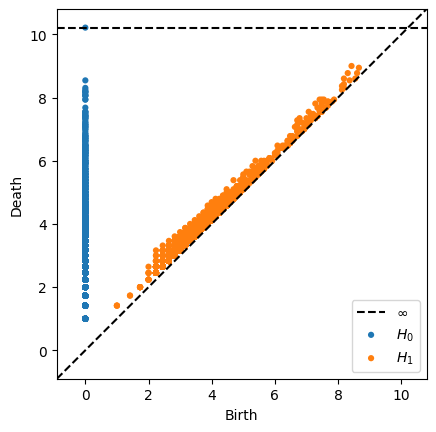

In [17]:
# Compute persistent homology on your data.
# maxdim=1 computes connected components (H0) and loops (H1).
ph_result = ripser(unique_vectors, maxdim=1)

# Plot persistence diagrams.
persim.plot_diagrams(ph_result['dgms'], show=True)

1 connected component at the end, no long lived loops.